**The usual market view is that gold and real yields are negatively correlated with each other. This notebook will plot the rolling correlation between them and verify the extent to which that view is true. The data used are:**

1) VanEck Gold Miners ETF 2) US 10Yr TIPS (treasury inflation protected securities) Yield

In [34]:
import os,datetime
import pandas as pd
import numpy as np
import requests
from urllib.request import urlopen
from requests import session
from bs4 import BeautifulSoup

data={}

downloadurl = "https://www.investing.com/instruments/HistoricalDataAjax"

# Posting the params and headers below with the correct curr_id will return the data
def params(curr_id):    
    dictionary = {
        'action' : 'historical_data',
        'curr_id' : curr_id,
        'st_date' : '01/01/2010',  
        'end_date' : '11/03/2020',
        'interval_sec' : 'Daily'
        }
        
    return dictionary

headers = {
    'Host':"www.investing.com",
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64; rv:52.0) Gecko/20100101 Firefox/52.0',
    'Accept':"text/plain, */*; q=0.01",
    'Accept-Language': "en-US,en;q=0.5",
    'Accept-Encoding':"gzip, deflate, br",
    'Content-Type' :"application/x-www-form-urlencoded",
    'X-Requested-With' :"XMLHttpRequest",
    'Referer' :"https://www.investing.com/indices/kospi-200-financials-historical-data",
}

# below is the code and name that corresponds to Gold Miners data at investing.com
code = ['40681']
names = ['VanEck Vectors Gold Miners']

# get_data() retrieves data from investing.com using the POST method
def get_data(code, ticker_name):
     if len(code) != len(ticker_name):
          raise AssertionError("both arguments must have the same length")

     with session() as c:   
         for i in range(0,len(code),1):
              # ticker is the name of the data you wnat to pull
             # create empty dictionary value to be converted to pandas Dataframe later
             data[ticker_name[i]] = {}
             param = params(code[i])
             req = c.post(downloadurl, data=param, headers=headers)
             soup = BeautifulSoup(req.content,"lxml")
             table = soup.find_all("tr")

             #Loop through each row of data, aggregating them into data_group dictionary
             data_group = {}
             for j in range(1,len(table)-1):
                 row = table[j].get_text().split('\n')
                 date = datetime.datetime.strptime(row[1],"%b %d, %Y").strftime('%Y-%m-%d')
            	 # data point lies in second index of each row
                 data_group[date] = row[2]
             data[ticker_name[i]] = data_group
     return pd.DataFrame(data).dropna(axis=0)

get_data(code, names).head()

,VanEck Vectors Gold Miners
2010-01-04,47.7100
2010-01-05,48.1700
2010-01-06,49.3400
2010-01-07,49.1000
2010-01-08,49.8400


Since investing.com doesn't have data on TIPS , I had to use FRED (Federal Reserve Economic Data from St. Louis Fed) to get the data. 

In [35]:
from urllib.request import urlopen

f_url='https://fred.stlouisfed.org/graph/fredgraph.csv?&id={}&mma=0&fq={}&fam=avg&transformation={}'

# below are the parameters to retrieve TIPS data from Fred. DFII10 is the code for 10Yr TIPS Yield
fred =('DFII10','10Yr TIPS Yield','daily','lin')

def gdata(f):
    data = urlopen(f_url.format(f[0],f[2],f[3])).read().split("\n".encode("utf-8"))
    dataset = [item.split(",".encode("utf-8"))[1] for item in data if ",".encode("utf-8") in item]
    index = [str(item.split(",".encode("utf-8"))[0], "utf-8") for item in data if ",".encode("utf-8") in item]
    dict = {"10Yr TIPS Yield": dataset}
    
    data = pd.DataFrame(dict, index=index)
    data.index = pd.to_datetime(data.index, errors="coerce")
    return data

gdata(fred).head()

,10Yr TIPS Yield
NaT,b'DFII10'
2003-01-02,b'2.43'
2003-01-03,b'2.43'
2003-01-06,b'2.46'
2003-01-07,b'2.42'


In [36]:
# indexing() will base the series with the first data point as 100
# it takes a DataFrame as input and will return a DataFrame of the same same with indexing applied 
def indexing(df):
    names = df.columns.values.tolist()
    new_names = [name+ " - indexed" for name in names]
    for i in range(len(names)):
        index = float(df.iloc[0,i])
        df[new_names[i]] = df[names[i]].apply(float)/index*100
    return df[new_names]

# rolling_mean() will apply a moving average to the series. Default is 30 day moving average
# it takes a DataFrame as input and will return a DataFrame of the same size with the moving average applied
def rolling_mean(df, days=30):
    df = pd.DataFrame(df)
    names = df.columns.values.tolist()
    new_names = [str(name) + " " + str(days) + "dma" for name in names]
    df[new_names] = df[names].rolling(window=days, center=False).mean()
    return df.iloc[:,len(names):].dropna(axis=0)

The data series are first indexed (so it can be visualized on one axis), then a moving average is applied. Finally, a rolling correlation is applied.

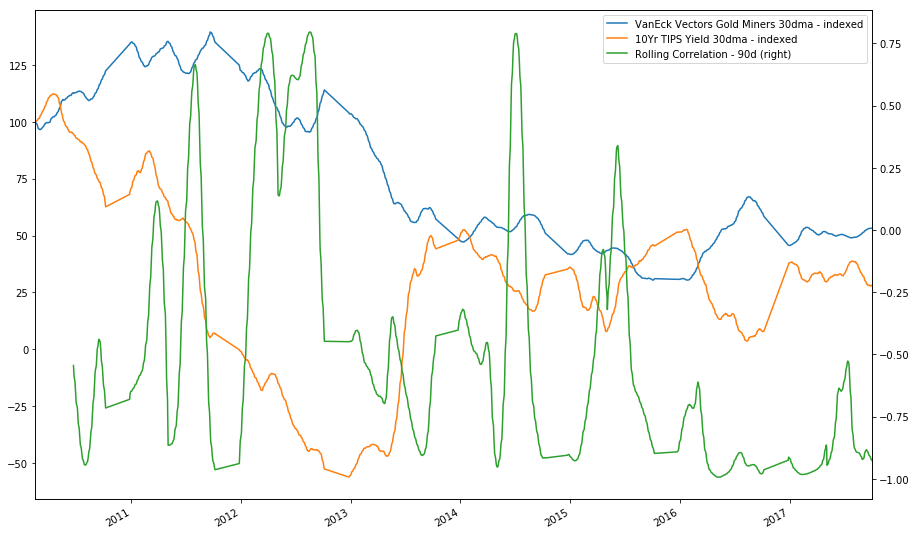

In [37]:
moving_average_window = 30

# Retrieving data from FRED and investing.com
fred_data = gdata(fred)
investing_data = get_data(code,names)

# Filter out null values and merge the two datasets together
df1 = pd.DataFrame(investing_data).dropna(axis=0)
df = pd.merge(df1, fred_data, how="left", left_index=True, right_index=True)
# Convert the bytes to floats
df["10Yr TIPS Yield"] = pd.to_numeric(df["10Yr TIPS Yield"], errors="coerce")

# Apply a moving average to both series
df = rolling_mean(df, days=moving_average_window)
# Indexing will index the first data point as 100 
df = indexing(df)

correlation_window = 90
# Apply rolling correlation
correl = df.iloc[:,0].rolling(window=correlation_window).corr(df.iloc[:,1])
df["Rolling Correlation - " + str(correlation_window) + "d"] = correl
df.index = pd.to_datetime(df.index)

import matplotlib.pyplot as plt
%matplotlib inline
df.plot(secondary_y = "Rolling Correlation - " + str(correlation_window) + "d", figsize=(15,10))

The chart shows that, although the two series are mainly negatively correlated, there have been many periods where the two series are actually positively correlated to each other. My next project will investigate why that is...